NLP analysis of all math articles from arXiv.
xml.gz files in `~/.metha`, loaded in Postgres.

344111 articles.

Identifier format before March 2007 differed from the present, though issue reconciled in the pulled data?

- Pulling data in db is painful. Load data in pd.DataFrame for prototyping.
- tf-idf to vectorize each document
- visualize with SVD or tSNE
- cluster by k-means or agglomerative
- Text summarization within each cluster

In [16]:
import pandas as pd
import numpy as np
from gensim.summarization import keywords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce

In [3]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

## Setup

In [4]:
import pickle
with open('../metha-all-math.pkl','rb') as f:
    df = pickle.load(f)
    
def remove_stopwords(text):
    return ' '.join([w for w in text.split() if w not in stopwords])

df['abstract'] = df['abstract'].apply(lambda t: t.replace('\n',' '))\
                    .apply(remove_stopwords)
df['title'] = df['title'].apply(lambda t: t.replace('\n',' '))\
                    .apply(remove_stopwords)

In [5]:
mask = df['categories'].apply(lambda cs: True if 'math.DS' in cs else False)
df_DS = df[mask]
abs_DS = df_DS.apply(lambda row: 
                     '. '.join([row['title'], row['abstract']]), axis=1)

In [11]:
df.shape

(344111, 6)

In [9]:
import twilio.rest
tw_cli = twilio.rest.Client('ACa7d89d1e86ec5a863118f0860e0a9b74',
                            'c060df5f1e0e64144a59ea9f58d3f7c7')
tw_cli.messages.create(to='+15037531533',
                      from_='+19713022281',
                      body='done running')

<Twilio.Api.V2010.MessageInstance account_sid=ACa7d89d1e86ec5a863118f0860e0a9b74 sid=SM34315b9d8e08495cb5f828e07f3f19d7>

## Run KMeans on 2-grams
Shape = (18550, 606274) for 2-grams. Computation with KMeans doesn't fit in memory.
Use minibatch version instead.
Even minibatch won't do for 3-grams.

2-grams don't cluster well, even with reassignment_ratio=0 and batch_size=1000.
13000 or more go to 1 cluster.
Are the clusters useful nevertheless? Run keyword extraction on it.

Visualize with IncrementalPCA -> tSNE

MiniBatchKMeans benchmark:
- n_clusters = 100, n_init=1 -> 44s
- n_clusters = 100, n_init=3 (default) -> 53s
- n_clusters = 100, reassignment_ratio=0.05 -> 53s

In [12]:
tfidf_vect = TfidfVectorizer(ngram_range=(2,2))
abs_DS_tfidf = tfidf_vect.fit_transform(abs_DS)

In [13]:
abs_DS_tfidf.shape

(18550, 1073068)

In [14]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=100, reassignment_ratio=0)
%time kmeans.fit(abs_DS_tfidf)

KeyboardInterrupt: 

In [10]:
clusters = kmeans.predict(abs_DS_tfidf)

In [11]:
pd.Series(clusters).value_counts()

4     14334
7       291
41      277
93      193
1       187
11      157
87      145
89      132
69      122
23      119
13      107
77      103
66       99
29       92
50       91
74       85
33       82
26       79
62       79
3        76
34       75
8        72
82       70
27       65
92       61
17       59
6        58
91       53
24       51
40       48
      ...  
75       11
2        10
43       10
19       10
59       10
79        9
44        9
60        9
84        9
21        9
76        9
15        8
47        7
95        7
46        7
83        7
5         7
30        6
38        6
70        6
86        6
32        6
72        6
63        5
64        5
97        4
56        4
31        4
58        3
16        1
Length: 100, dtype: int64

## Keywords of clusters within a category
Attempt to improve keyword extraction by creating clusters before extraction. Tf-idf seems to work!!

gensim's keywords produces unimpressive results.
It doesn't return phrases.

Let visualization aid selection of k = #clusters.
tSNE doc recommends using (Truncated) SVD to reduce dimension to ~=50 before applying tSNE.
*Issue*. Memory consumption large for n-grams.

kmeans benchmark:
- (18550, 30347), n_clusters=50 -> 41s for n_init=1
- (18550, 30347), n_clusters=100 -> 42s

TruncatedSVD benchmark:
- (18550, 30347), n_components=100 -> 5s

TSNE benchmark (need to pass data through SVD first):
- (18550, 100) -> 9m

In [6]:
tfidf_vect = TfidfVectorizer()
tfidf_vect = tfidf_vect.fit(abs_DS)

In [7]:
abs_DS_tfidf = tfidf_vect.transform(abs_DS)

In [9]:
# Eat too much memory for 2-grams
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=100)
pca.fit(abs_DS_tfidf)
abs_DS_svd = pca.transform(abs_DS_tfidf)

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE()
abs_DS_tsne=tsne.fit_transform(abs_DS_svd)

In [39]:
abs_DS_tsne.shape

(18550, 2)

In [34]:
abs_DS_tfidf.shape

(18550, 30347)

In [8]:
kmeans = KMeans(n_clusters=100).fit(abs_DS_tfidf)
cluster = kmeans.predict(abs_DS_tfidf)

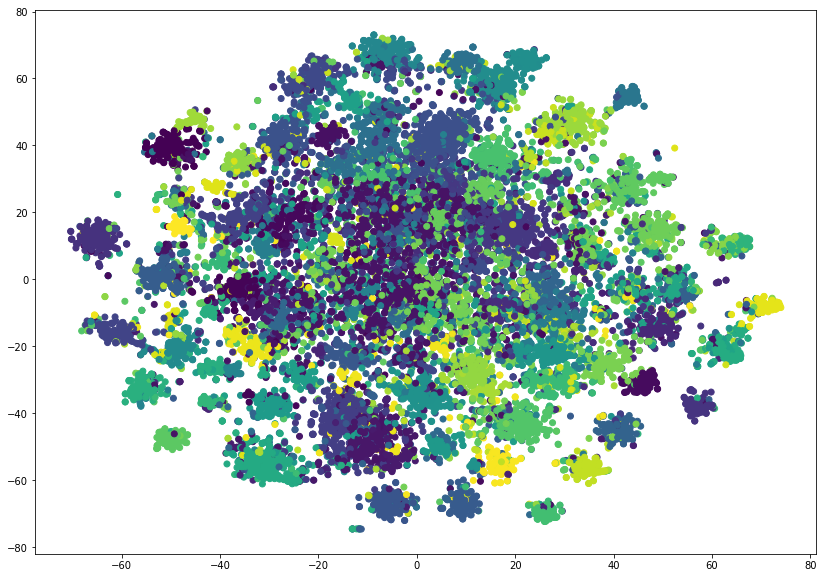

In [17]:
#visualization
plt.figure(figsize=(14,10))
plt.scatter(abs_DS_tsne[:, 0], abs_DS_tsne[:, 1], c=cluster, cmap=plt.cm.viridis)

In [12]:
pd.Series(cluster).value_counts()

12    2264
20     682
67     537
75     420
15     370
18     325
3      318
58     294
46     293
22     286
74     285
34     265
43     262
21     260
65     251
62     239
10     239
38     225
5      223
63     218
81     218
27     218
16     212
76     206
37     205
87     202
92     198
35     191
29     188
80     187
      ... 
64     115
82     115
39     110
28     106
30     106
9      105
55     104
86     102
41     100
73      98
60      96
45      94
83      93
51      91
8       91
57      90
14      87
11      86
26      79
85      75
47      73
69      71
48      69
40      65
79      65
84      64
17      53
95      42
88      40
94      21
Length: 100, dtype: int64

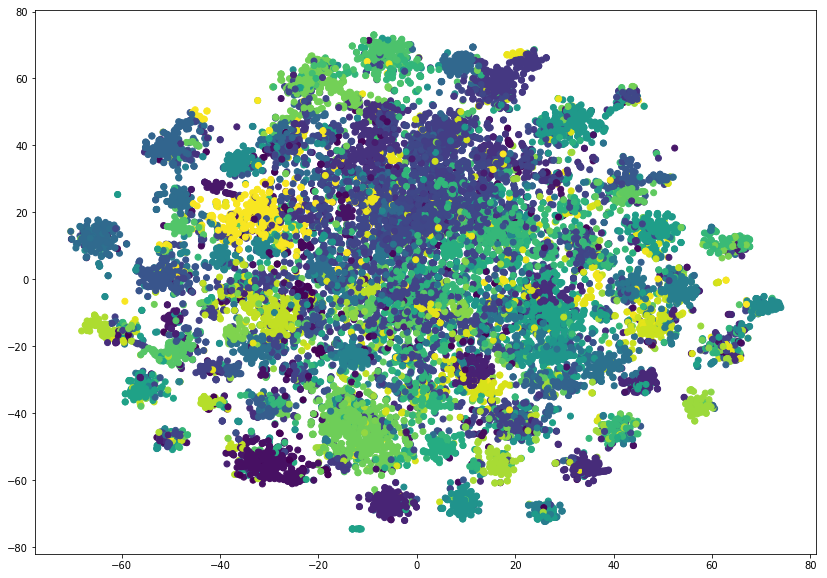

In [68]:
# compare minibatch kmeans with normal version, which did a decent job identifying outer clusters.
# larger batch_size and ratio=0 produce similar clusters
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=1000, reassignment_ratio=0).fit(abs_DS_tfidf)
cluster = kmeans.predict(abs_DS_tfidf)
plt.figure(figsize=(14,10))
plt.scatter(abs_DS_tsne[:, 0], abs_DS_tsne[:, 1], c=cluster, cmap=plt.cm.viridis)
# there are distinctly clusters. 100 clusters seem about right.

In [10]:
# now do the same thing as 'Keywords of a category' for each cluster
# dict {key=word: val=}
abs_clusters = pd.DataFrame({
    'cluster': cluster,
    'text': abs_DS
})

In [32]:
import heapq
def rank_phrases(text, n):
    tfidf_vect = TfidfVectorizer(ngram_range=(2,4))
    text_vect = tfidf_vect.fit_transform(text)
    text_vect = np.asarray(text_vect.sum(axis=0)).ravel()
    tfidf_dict = dict()
    idf = tfidf_vect.idf_
    for k, v in tfidf_vect.vocabulary_.items():
        tfidf_dict[k] = text_vect[v]
    return heapq.nlargest(n, tfidf_dict, key=tfidf_dict.get)

In [34]:
for j in range(100):
    c = abs_clusters[abs_clusters['cluster']==j]
    print(rank_phrases(c['text'], 2))

['quantum ergodicity', 'classical quantum']
['non integrability', 'integrable systems']
['group actions', 'higher rank']
['periodic solutions', 'navier stokes']
['topological entropy', 'topological pressure']
['differential equations', 'ordinary differential']
['holomorphic foliations', 'codimension one']
['dynamical systems', 'white noise']
['continued fraction', 'continued fractions']
['free group', 'free groups']
['hausdorff dimension', 'iterated function']
['interval exchange', 'exchange transformations']
['we show', 'in paper']
['dynamical systems', 'sarnak conjecture']
['reeb orbits', 'contact manifolds']
['we show', 'we prove']
['body problem', 'three body']
['escape rate', 'escape rates']
['maps we', 'unimodal maps']
['partially hyperbolic', 'hyperbolic diffeomorphisms']
['dynamical systems', 'in paper']
['invariant measures', 'probability measures']
['reaction networks', 'chemical reaction']
['omega omega', 'omega limit']
['entire functions', 'transcendental entire']
['mathcal

In [26]:
cluster0 = abs_clusters[abs_clusters['cluster']==0]
rank_phrases(cluster0['text'],3,50)

['quantum unique ergodicity',
 'open quantum systems',
 'quantum dynamical entropies',
 'open quantum maps',
 'quantum iterated function',
 'locally symmetric spaces',
 'classical quantum dynamics',
 'quantum information space',
 'quantum markov chains',
 'fractal weyl law',
 'shannon mcmillan theorem',
 'quantum many body',
 'many body problems',
 'iterated function systems',
 'negatively curved manifolds',
 'systems associated classical',
 'associated classical root',
 'classical root systems',
 'markov chains cayley',
 'chains cayley tree',
 'model cayley tree',
 'cayley tree order',
 'braided quantum group',
 'completely integrable systems',
 'dynamical point view',
 'point view quantum',
 'view quantum information',
 'multiple quantum coherences',
 'quantum toric integrable',
 'toric integrable systems',
 'quantum stochastic systems',
 'bounds multi commutators',
 'value problem quantum',
 'quantum ergodicity theorem',
 'aharonov anandan phase',
 'mathematically quantum dynamical'

In [14]:
cluster0_all = reduce(lambda s, t: ' '.join([s,t]), 
                      cluster0['text'].values)

In [19]:
keywords(cluster0_all, ratio=5e-3, split=True)

['quantum',
 'dynamics',
 'dynamical',
 'dynamic',
 'classical',
 'classically',
 'systems',
 'time',
 'times',
 'operator',
 'operators',
 'operation',
 'result',
 'results',
 'resulting']

## Keywords of a category

Some success with tf-idf ranking! 'dynamical systems' comes #1, and 'hausdorff dimension', 'topological entropy', 'lyapunov exponents', etc. show up. n-grams are stronger than (n+1)-grams, so better to run tf-idf separately for each n. Junks such as 'in paper study' and 'we also prove' are present.

gensim's textrank (summarization.keywords) won't run. Memory consumption issue. Try davidadamojr's implementation using Levenshtein metric as well.

In [104]:
# textrank approach
abs_DS_all = reduce(lambda s, t: ' '.join([s,t]), abs_DS.values)

In [108]:
# %time keywords(abs_DS_all, ratio=0.01)

KeyboardInterrupt: 

In [109]:
#tfidf approach
tfidf_vect = TfidfVectorizer(ngram_range=(4,4))
abs_DS_tfidf = tfidf_vect.fit_transform(abs_DS)

In [110]:
len(tfidf_vect.idf_)
# 30347 for 1-gram
# 1201517 for 4-gram
# 1679342 for ngram_range=(2,3)
# 2274585 for (3,4)
# 2880859 for (2,4)

1201517

In [111]:
abs_DS_tfidf = np.asarray(abs_DS_tfidf.sum(axis=0)).ravel()

In [112]:
tfidf_dict = dict()
idf = tfidf_vect.idf_
for k, v in tfidf_vect.vocabulary_.items():
    tfidf_dict[k] = abs_DS_tfidf[v]

In [113]:
import heapq
heapq.nlargest(50, tfidf_dict, key=tfidf_dict.get)

['restricted three body problem',
 'stochastic partial differential equations',
 'the main result paper',
 'non uniformly expanding maps',
 'absolutely continuous invariant probability',
 'nonlinear schr odinger equation',
 'give necessary sufficient conditions',
 'dynamical systems in paper',
 'absolutely continuous invariant measure',
 'almost sure invariance principle',
 'systems in paper study',
 'we give sufficient conditions',
 'infinitely many periodic orbits',
 'input to state stability',
 'system ordinary differential equations',
 'rational maps riemann sphere',
 'dynamical systems we show',
 'ergodic probability measure preserving',
 'this paper devoted study',
 'we give necessary sufficient',
 'continuous invariant probability measure',
 'give necessary sufficient condition',
 'hausdorff dimension julia set',
 'locally compact second countable',
 'absolutely continuous invariant measures',
 'planar three body problem',
 'infinite measure preserving transformations',
 'dynami

## Are clusters compatible with categories?
- There are 33 math categories; 133 non-math.


### kmeans runtime
- (dataset, `k_per_category`, `n_categories`, `n_init`, `n_jobs`) -> time
- `timestamp >= 2017-01-01`, 1, 143, 1, _  ->  3m50s
- full, 1, 150, 1, _ -> 1h14m
- `df_161`, 1, 1, 150, 1, _ ->  7m

*Note*: `n_jobs` greater than 1 irrelevant when `n_init` is 1.

In [24]:
# work with a smaller set
(df['submitted'] >= '2017-01-01').sum() # => 27278
(df['submitted'] >= '2016-01-01').sum() # => 63639
(df['submitted'] >= '2015-01-01').sum() # => 98358
(df['submitted'] >= '2014-01-01').sum() # => 130453

27278

In [25]:
df_17 = df[df['submitted'] >= '2017-01-01']
abstracts_17 = df_17['abstract']
tfidf_vect = TfidfVectorizer()
abs_vect_17 = tfidf_vect.fit_transform(abstracts_17)

In [3]:
df_16 = df[df['submitted'] >= '2016-01-01']
abstracts_16 = df_16['abstract']
tfidf_vect = TfidfVectorizer()
abs_vect_16 = tfidf_vect.fit_transform(abstracts_16)

In [4]:
abs_vect_16.shape
# 157615 words in corpus; 69408 for df_16; 46187 for df_17

(63639, 69408)

In [48]:
tfidf_vect = TfidfVectorizer()
abstracts = df['abstract']
abs_vect = tfidf_vect.fit_transform(abstracts)

In [5]:
k_per_category = 1 # see if categories correspond to clusters
n_categories = 150 # 163 for full df; 143 for df_17
%time kmeans = KMeans(n_clusters=k_per_category * n_categories,\
                      n_init=1,\
                     n_jobs=1).fit(abs_vect_16)

CPU times: user 7min 1s, sys: 3.57 s, total: 7min 4s
Wall time: 7min 3s


In [13]:
abs_clusters = kmeans.predict(abs_vect_16)

In [47]:
abs_clusters[:5]

array([ 92,  84, 114,  51,  50], dtype=int32)

In [93]:
df_16['cluster'] = abs_clusters

In [104]:
categories_16 = set(
    [item for sublist in df_16['categories'] 
     for item in sublist]
) # 147 unique categories
cluster_dict = {i: {k: 0 for k in categories_16} for i in range(150)}

In [105]:
for _, (_, _, categories, _, _, _, cluster) in df_16.iterrows():
    d = cluster_dict[int(cluster)]
    for c in categories:
        d[c] = d[c]+1

In [106]:
max_categories = [ max(cluster_dict[i], key=cluster_dict[i].get)
                  for i in range(150) ]

In [110]:
for i, c in enumerate(max_categories):
    if c == 'math.DS':
        print(i)
# DS clusters are 35 and 126

35
126


In [111]:
cluster_dict[35]

{'astro-ph.CO': 1,
 'astro-ph.EP': 3,
 'astro-ph.GA': 0,
 'astro-ph.HE': 0,
 'astro-ph.IM': 1,
 'astro-ph.SR': 0,
 'cond-mat.dis-nn': 3,
 'cond-mat.mes-hall': 3,
 'cond-mat.mtrl-sci': 1,
 'cond-mat.other': 1,
 'cond-mat.quant-gas': 1,
 'cond-mat.soft': 2,
 'cond-mat.stat-mech': 25,
 'cond-mat.str-el': 3,
 'cond-mat.supr-con': 0,
 'cs.AI': 5,
 'cs.AR': 0,
 'cs.CC': 0,
 'cs.CE': 1,
 'cs.CG': 1,
 'cs.CL': 0,
 'cs.CR': 0,
 'cs.CV': 0,
 'cs.CY': 0,
 'cs.DB': 0,
 'cs.DC': 2,
 'cs.DL': 0,
 'cs.DM': 2,
 'cs.DS': 1,
 'cs.ET': 2,
 'cs.FL': 2,
 'cs.GR': 0,
 'cs.GT': 1,
 'cs.HC': 0,
 'cs.IR': 0,
 'cs.IT': 39,
 'cs.LG': 5,
 'cs.LO': 1,
 'cs.MA': 2,
 'cs.MM': 0,
 'cs.MS': 1,
 'cs.NA': 3,
 'cs.NE': 1,
 'cs.NI': 2,
 'cs.OH': 0,
 'cs.OS': 0,
 'cs.PF': 0,
 'cs.PL': 0,
 'cs.RO': 8,
 'cs.SC': 2,
 'cs.SD': 0,
 'cs.SE': 0,
 'cs.SI': 0,
 'cs.SY': 80,
 'eess.SP': 0,
 'gr-qc': 5,
 'hep-lat': 1,
 'hep-ph': 3,
 'hep-th': 14,
 'math-ph': 103,
 'math.AC': 3,
 'math.AG': 9,
 'math.AP': 65,
 'math.AT': 2,
 'math.CA'

In [117]:
df_16[df_16['cluster'] == 35]['title']

3350      Planar S-systems: Global stability and the cen...
3366      Interacting and noninteracting integrable systems
3481                         A Core Theory of Delay Systems
3557             Compositionality of the Runge-Kutta Method
3582      A homogenization theorem for Langevin systems ...
3610      Differential-functional dynamical systems, the...
3927      Where and When Orbits of Chaotic Systems Prefe...
3999                  How do nonholonomic integrators work?
5557      A Characterization of Integral ISS for Switche...
5665      Output Average Consensus Over Heterogeneous Mu...
5668      Systems of four coupled one sided Sylvester-ty...
5715      The center problem for the Lotka reactions wit...
5967      Robustness Analysis of Systems' Safety through...
5987      Robust Stability of Optimization-based State E...
6108      Dynamics and evolution of planets in mean-moti...
6128                                 Approximation Dynamics
6130      Lax orthogonal factorisations 

## Interacting with Postgres

In [35]:
import sys
sys.path.append('..') if '..' not in sys.path else None
from app import db
from models import Article, Author, Category, article_author, article_category

In [4]:
query = db.session().query(Article)

In [30]:
query.filter(
    (Article.submitted >= '2016-01-01') & (Article.submitted <= '2016-12-31')
).count()

36361

In [33]:
query.filter(Article.submitted >= '2017-01-01').count()

27278

In [52]:
query.filter(
    (Article.submitted >= '2016-01-01') & (Article.submitted <= '2016-12-31')
).count()

36361

In [34]:
# query with join example. need Table.c to access columns 
db.session.query(Article.id, Category.name) \
.filter(Article.id == 1) \
.filter(Article.id == article_category.c.article_id) \
.filter(Category.id == article_category.c.category_id) \
.all()

[(1, 'cs.SY'), (1, 'cs.AI'), (1, 'math.OC')]

In [37]:
# num of distinct categories = 13627
def get_categories(i):
    return [c.name for c in db.session.query(Article.id, Category.name) \
    .filter(Article.id == i) \
    .filter(Article.id == article_category.c.article_id) \
    .filter(Category.id == article_category.c.category_id) \
    .all()]

In [44]:
cs = [get_categories(i+1) for i in range(query.count())]
# this takes a while!

In [50]:
len(set( [tuple(x) for x in cs] )) # list is not hashable but tuple is

13627

In [43]:
# 163 categories
categories_all = db.session.query(Category).filter(Category.name.like('math%')).all()
categories_all = list(map(lambda c: c.name, categories_all))

In [51]:
open('math_categories.txt','r').read().splitlines()

['math.OC',
 'math.IT',
 'math.AP',
 'math.OA',
 'math.RA',
 'math.NA',
 'math.SG',
 'math.AT',
 'math.NT',
 'math.AG',
 'math.CO',
 'math.GT',
 'math.DG',
 'math-ph',
 'math.MP',
 'math.DS',
 'math.QA',
 'math.SP',
 'math.CA',
 'math.PR',
 'math.LO',
 'math.FA',
 'math.MG',
 'math.GN',
 'math.CV',
 'math.CT',
 'math.KT',
 'math.GR',
 'math.RT',
 'math.ST',
 'math.HO',
 'math.AC',
 'math.GM']

In [57]:
# 33 math categories
db.session.query(Category.name).filter(Category.name.like('math%')).count()

33

In [58]:
# all articles are math
db.session.query(article_category.c.article_id)\
.filter(Category.id == article_category.c.category_id)\
.filter(Category.name.like('math%'))\
.distinct().count()

344110